In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

References:
- https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
- https://stackoverflow.com/questions/50375985/pandas-add-column-with-value-based-on-condition-based-on-other-columns
- https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
https://stackoverflow.com/questions/44111307/python-pandas-count-rows-based-on-column
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
https://datatofish.com/line-chart-python-matplotlib/
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [2]:
crashes = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv', low_memory=False)

In [3]:
persons = pd.read_csv('Motor_Vehicle_Collisions_-_Person.csv', low_memory=False)

In [4]:
crashes.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [61]:
crashes.loc[:, 'CRASH_YEAR'] = crashes_persons['CRASH DATE'].astype(np.str_).apply(lambda x: int(x.split('/')[-1]))

In [5]:
persons.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

In [6]:
crashes['CONTRIBUTING FACTOR VEHICLE 1'].unique()

array(['Driver Inattention/Distraction', 'Turning Improperly',
       'Following Too Closely', 'Unsafe Speed', 'Unspecified',
       'Backing Unsafely', 'Unsafe Lane Changing',
       'Traffic Control Disregarded', 'Passing Too Closely',
       'Failure to Yield Right-of-Way', nan, 'Other Vehicular',
       'Passing or Lane Usage Improper', 'Driverless/Runaway Vehicle',
       'Reaction to Uninvolved Vehicle', 'Illnes', 'Driver Inexperience',
       'Obstruction/Debris', 'Steering Failure', 'Alcohol Involvement',
       'Tire Failure/Inadequate',
       'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'View Obstructed/Limited', 'Outside Car Distraction',
       'Pavement Slippery', 'Aggressive Driving/Road Rage',
       'Passenger Distraction', 'Oversized Vehicle',
       'Traffic Control Device Improper/Non-Working',
       'Failure to Keep Right', 'Drugs (illegal)', 'Glare', 'Fell Asleep',
       'Pavement Defective', 'Brakes Defective', 'Eating or Drinking',
       'L

In [7]:
persons['CONTRIBUTING_FACTOR_1'].value_counts()

Unspecified                                              36161
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     8802
Driver Inattention/Distraction                            1797
Failure to Yield Right-of-Way                             1434
Traffic Control Disregarded                                865
Alcohol Involvement                                        851
Other Vehicular                                            632
View Obstructed/Limited                                    350
Cell Phone (hand-Held)                                     226
Backing Unsafely                                           155
Passing or Lane Usage Improper                             125
Passing Too Closely                                        104
Aggressive Driving/Road Rage                                95
Pavement Slippery                                           79
Passenger Distraction                                       77
Unsafe Speed                                           

## Hypothesis:
#### Of all collisions occurring late in the night (between 12 am - 5 am), the majority are caused due to overspeeding.

In [8]:
def get_night_crashes(crashes):
    
    time_data = crashes['CRASH TIME']
    crashes['CRASH TIME'] = crashes['CRASH TIME'].apply(lambda x: datetime.strptime(x, "%H:%M").time())

    night_crash_data = crashes[(crashes['CRASH TIME'] < time(5, 0, 0))]

    return night_crash_data

In [9]:
night_crash_data = get_night_crashes(crashes)

In [10]:
# night_crash_data['hasUnsafeSpeed'] = np.where((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1']=='Unsafe Speed' | night_crash_data['CONTRIBUTING FACTOR VEHICLE 2']=='Unsafe Speed' | night_crash_data['CONTRIBUTING FACTOR VEHICLE 3']=='Unsafe Speed' | night_crash_data['CONTRIBUTING FACTOR VEHICLE 4']=='Unsafe Speed' | night_crash_data['CONTRIBUTING FACTOR VEHICLE 5']=='Unsafe Speed'), True, False)

In [11]:
# night_crash_vehicle1 = night_crash_data[(night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].notnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isnull())]
# night_crash_vehicle1

In [12]:
# night_crash_vehicle1['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

In [13]:
# night_crash_vehicle2 = night_crash_data[(night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].notnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].notnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isnull() & night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isnull())]
# night_crash_vehicle2

In [14]:
# night_crash_vehicle2['CONTRIBUTING FACTOR VEHICLE 2'].value_counts()

In [15]:
# night_crash_data

In [16]:
night_crash_data = night_crash_data.assign(hasUnsafeSpeed=False)

In [17]:
night_crash_data.loc[((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1']=='Unsafe Speed') | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2']=='Unsafe Speed') | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3']=='Unsafe Speed') | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4']=='Unsafe Speed') | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5']=='Unsafe Speed')), 'hasUnsafeSpeed'] = True

In [18]:
night_crash_data

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,hasUnsafeSpeed
11,06/16/2018,00:05:00,MANHATTAN,10002,40.719970,-73.992905,"(40.71997, -73.992905)",DELANCEY STREET,CHRYSTIE STREET,NaN,...,NaN,NaN,NaN,3922402,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,False
12,06/19/2018,01:00:00,QUEENS,11377,40.758960,-73.898384,"(40.75896, -73.898384)",NaN,NaN,30-46 69 STREET,...,NaN,NaN,NaN,3926636,Sedan,Sedan,NaN,NaN,NaN,False
18,06/15/2018,00:52:00,NaN,NaN,40.780125,-73.953040,"(40.780125, -73.95304)",3 AVENUE,NaN,NaN,...,NaN,NaN,NaN,3924614,Bike,Taxi,NaN,NaN,NaN,False
25,06/04/2018,00:53:00,BROOKLYN,11238,40.673290,-73.957030,"(40.67329, -73.95703)",STERLING PLACE,FRANKLIN AVENUE,NaN,...,NaN,NaN,NaN,3915438,Sedan,Sedan,NaN,NaN,NaN,False
54,06/26/2018,01:50:00,QUEENS,11101,40.748943,-73.954110,"(40.748943, -73.95411)",NaN,NaN,5-26 45 AVENUE,...,NaN,NaN,NaN,3929104,Armored Truck,Sedan,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731715,07/01/2012,02:45:00,BROOKLYN,11226,40.643185,-73.949729,"(40.6431849, -73.9497292)",EAST 29 STREET,CLARENDON ROAD,NaN,...,NaN,NaN,NaN,135073,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,False
1731716,07/01/2012,02:30:00,BRONX,10464,40.856551,-73.791364,"(40.8565513, -73.7913635)",CITY ISLAND AVENUE,BRIDGE STREET,NaN,...,Unspecified,Unspecified,NaN,88523,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,False
1731717,07/01/2012,04:00:00,QUEENS,11372,40.747137,-73.892408,"(40.7471367, -73.8924084)",BROADWAY,73 STREET,NaN,...,NaN,NaN,NaN,279798,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,False
1731720,07/01/2012,03:30:00,BROOKLYN,11234,40.616509,-73.933919,"(40.6165086, -73.9339188)",KIMBALL STREET,QUENTIN ROAD,NaN,...,NaN,NaN,NaN,125661,PASSENGER VEHICLE,AMBULANCE,NaN,NaN,NaN,False


In [19]:
unsafe_speed_metrics = night_crash_data['hasUnsafeSpeed'].value_counts().to_frame()

In [20]:
percentage_unsafe_speed_collisions = unsafe_speed_metrics.iloc[1]*100/night_crash_data.shape[0]

In [21]:
percentage_unsafe_speed_collisions

hasUnsafeSpeed    2.687928
Name: True, dtype: float64

In [22]:
unwanted_contributing_factors = ['1','80','Unspecified']

In [23]:
night_crash_data['isUnspecified'] = np.where((((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isin(unwanted_contributing_factors)) | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isnull())) & ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isin(unwanted_contributing_factors)) | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isnull())) & ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isin(unwanted_contributing_factors))  | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isnull())) & ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isin(unwanted_contributing_factors))  | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isnull())) & ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isin(unwanted_contributing_factors))  | (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isnull()))), True, False)

In [24]:
invalid_night_crash_data_metrics = night_crash_data['isUnspecified'].value_counts().to_frame()

In [25]:
percentage_invalid_collision_data = invalid_night_crash_data_metrics.iloc[1]*100/night_crash_data.shape[0]

In [26]:
percentage_invalid_collision_data

isUnspecified    34.79346
Name: True, dtype: float64

## Hypothesis:

#### Of all crashes, a majority number is caused by persons between the age of 16-25.

In [27]:
crashes_persons = pd.merge(crashes, persons, left_on='COLLISION_ID', right_on='COLLISION_ID', how='inner')
crashes_persons.shape

(4117932, 49)

In [28]:
crashes_persons.loc[:, 'CRASH_YEAR'] = crashes_persons['CRASH_DATE'].astype(np.str_).apply(lambda x: x.split('/')[-1])

In [29]:
del crashes_persons['CRASH_DATE']
del crashes_persons['CRASH_TIME']
del crashes_persons['UNIQUE_ID']

In [30]:
crashes_persons.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'PERSON_ID', 'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE',
       'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_RO

In [31]:
crashes_persons['PERSON_TYPE'].unique()

array(['Occupant', 'Pedestrian', 'Bicyclist'], dtype=object)

In [32]:
crashes_persons[(crashes_persons['VEHICLE_ID'].isna())][['COLLISION_ID', 'PERSON_TYPE', 'POSITION_IN_VEHICLE']]

,COLLISION_ID,PERSON_TYPE,POSITION_IN_VEHICLE
2,3916262,Pedestrian,NaN
13,3929617,Pedestrian,NaN
30,3920134,Occupant,NaN
59,3926636,Occupant,NaN
61,3916004,Pedestrian,NaN
...,...,...,...
4117897,26084,Pedestrian,NaN
4117898,187677,Pedestrian,NaN
4117914,208724,Pedestrian,NaN
4117920,32046,Pedestrian,NaN


In [33]:
crashes_persons[(crashes_persons['VEHICLE_ID'].isna()) & 
                (crashes_persons['PERSON_TYPE'] == 'Bicyclist')][['COLLISION_ID', 'PERSON_TYPE', 'POSITION_IN_VEHICLE']]

,COLLISION_ID,PERSON_TYPE,POSITION_IN_VEHICLE


In [34]:
crashes_persons.drop(crashes_persons.loc[crashes_persons['VEHICLE_ID'].isna()].index, inplace=True)
crashes_persons.shape

(3956766, 47)

In [35]:
data_subset = crashes_persons[crashes_persons['POSITION_IN_VEHICLE'] == 'Driver'][['COLLISION_ID', 'VEHICLE_ID', 'PERSON_TYPE', 'POSITION_IN_VEHICLE', 'PERSON_AGE']]

In [36]:
data_subset

,COLLISION_ID,VEHICLE_ID,PERSON_TYPE,POSITION_IN_VEHICLE,PERSON_AGE
1,3916262,18655232.0,Occupant,Driver,57.0
5,3928600,18762804.0,Occupant,Driver,38.0
6,3928600,18762803.0,Occupant,Driver,39.0
8,3921967,18643741.0,Occupant,Driver,43.0
9,3921967,18643742.0,Occupant,Driver,83.0
...,...,...,...,...,...
4112338,4252952,19666652.0,Occupant,Driver,32.0
4112837,3497539,17299497.0,Occupant,Driver,19.0
4113965,3721654,17625363.0,Occupant,Driver,58.0
4115185,3943425,18606945.0,Occupant,Driver,39.0


In [37]:
data_subset.loc[:, 'age16-25'] = np.where((data_subset['PERSON_AGE'] > 15) & 
                                          (data_subset['PERSON_AGE'] < 26), True, False)

In [38]:
data_subset['age16-25'].value_counts()

False    1266515
True      207029
Name: age16-25, dtype: int64

## Hypothesis

#### The number of collisions increased with an increase in population

Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

In [39]:
NYC_Population_data = {'Year':  [2012,2013,2014,2015,2016,2017,2018,2019,2020],
        'Population': [8348030,8398740,8437390,8468180,8475980,8438270, 8398750, 8361040, 8323340],
        }

NYC_Population = pd.DataFrame (NYC_Population_data, columns = ['Year','Population'])
NYC_Population

,Year,Population
0,2012,8348030
1,2013,8398740
2,2014,8437390
3,2015,8468180
4,2016,8475980
5,2017,8438270
6,2018,8398750
7,2019,8361040
8,2020,8323340


In [40]:
NYC_area = 300.4 #(in sq miles) Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

In [41]:
NYC_Population['Population_Density'] = NYC_Population['Population'].apply(lambda x: x/NYC_area)

In [42]:
NYC_Population

,Year,Population,Population_Density
0,2012,8348030,27789.713715
1,2013,8398740,27958.521971
2,2014,8437390,28087.183755
3,2015,8468180,28189.680426
4,2016,8475980,28215.645806
5,2017,8438270,28090.113182
6,2018,8398750,27958.555260
7,2019,8361040,27833.022636
8,2020,8323340,27707.523302


In [43]:
crashes_data = crashes.copy()
crashes_data

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,06/07/2018,21:29:00,BROOKLYN,11235,40.593807,-73.940620,"(40.593807, -73.94062)",AVENUE X,NOSTRAND AVENUE,NaN,...,NaN,NaN,NaN,NaN,3916262,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
1,06/24/2018,20:00:00,QUEENS,11377,40.740160,-73.895250,"(40.74016, -73.89525)",QUEENS BOULEVARD,45 AVENUE,NaN,...,Turning Improperly,NaN,NaN,NaN,3928600,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
2,06/15/2018,23:20:00,NaN,NaN,40.704388,-73.994576,"(40.704388, -73.994576)",BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,Unspecified,NaN,NaN,3921967,Sedan,Sedan,Sedan,NaN,NaN
3,06/26/2018,16:30:00,NaN,NaN,40.726930,-73.996666,"(40.72693, -73.996666)",BLEECKER STREET,NaN,NaN,...,NaN,NaN,NaN,NaN,3929617,Bike,NaN,NaN,NaN,NaN
4,06/07/2018,15:30:00,MANHATTAN,10036,40.756664,-73.988434,"(40.756664, -73.988434)",NaN,NaN,253 WEST 42 STREET,...,Unspecified,NaN,NaN,NaN,3917316,Box Truck,Bus,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731717,07/01/2012,04:00:00,QUEENS,11372,40.747137,-73.892408,"(40.7471367, -73.8924084)",BROADWAY,73 STREET,NaN,...,Prescription Medication,NaN,NaN,NaN,279798,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN
1731718,07/01/2012,05:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Unspecified,NaN,NaN,NaN,2879030,PASSENGER VEHICLE,PICK-UP TRUCK,NaN,NaN,NaN
1731719,07/01/2012,06:55:00,QUEENS,11385,40.708991,-73.909700,"(40.7089912, -73.9097003)",HARMAN STREET,FAIRVIEW AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,213209,PASSENGER VEHICLE,UNKNOWN,NaN,NaN,NaN
1731720,07/01/2012,03:30:00,BROOKLYN,11234,40.616509,-73.933919,"(40.6165086, -73.9339188)",KIMBALL STREET,QUENTIN ROAD,NaN,...,Other Vehicular,NaN,NaN,NaN,125661,PASSENGER VEHICLE,AMBULANCE,NaN,NaN,NaN


In [44]:
crashes_data.loc[:, 'CRASH_YEAR'] = crashes_data['CRASH DATE'].astype(np.str_).apply(lambda x: x.split('/')[-1])

In [45]:
crashes_data['CRASH_YEAR'].unique()

array(['2018', '2017', '2019', '2020', '2012', '2016', '2015', '2014',
       '2013'], dtype=object)

In [46]:
crashes_total = crashes_data.groupby(['CRASH_YEAR'], sort=False).size().reset_index(name='Total_Crashes')

In [47]:
crashes_total['CRASH_YEAR'] = crashes_total['CRASH_YEAR'].astype('int64')

In [48]:
crashes_population = pd.merge(crashes_total, NYC_Population, left_on='CRASH_YEAR', right_on='Year', how='inner')

In [49]:
crashes_population

,CRASH_YEAR,Total_Crashes,Year,Population,Population_Density
0,2018,231562,2018,8398750,27958.555260
1,2017,231007,2017,8438270,28090.113182
2,2019,211481,2019,8361040,27833.022636
3,2020,99840,2020,8323340,27707.523302
4,2012,100541,2012,8348030,27789.713715
5,2016,229830,2016,8475980,28215.645806
6,2015,217694,2015,8468180,28189.680426
7,2014,206033,2014,8437390,28087.183755
8,2013,203734,2013,8398740,27958.521971


In [50]:
crashes_population.loc[:, 'Crashes_per_capita'] = crashes_population['Total_Crashes']/crashes_population['Population']

In [51]:
crashes_population_sorted = crashes_population.sort_values(by=['Year'])
crashes_population_sorted

,CRASH_YEAR,Total_Crashes,Year,Population,Population_Density,Crashes_per_capita
4,2012,100541,2012,8348030,27789.713715,0.012044
8,2013,203734,2013,8398740,27958.521971,0.024258
7,2014,206033,2014,8437390,28087.183755,0.024419
6,2015,217694,2015,8468180,28189.680426,0.025707
5,2016,229830,2016,8475980,28215.645806,0.027115
1,2017,231007,2017,8438270,28090.113182,0.027376
0,2018,231562,2018,8398750,27958.555260,0.027571
2,2019,211481,2019,8361040,27833.022636,0.025294
3,2020,99840,2020,8323340,27707.523302,0.011995


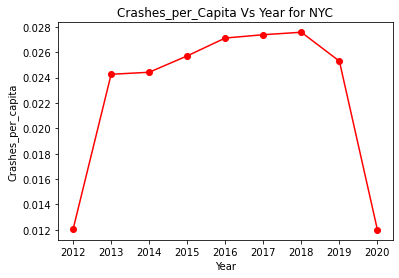

In [52]:
plt.plot(crashes_population_sorted['Year'], crashes_population_sorted['Crashes_per_capita'], color='red', marker='o')
plt.title('Crashes_per_Capita Vs Year for NYC')
plt.xlabel('Year')
plt.ylabel('Crashes_per_capita')
plt.show()

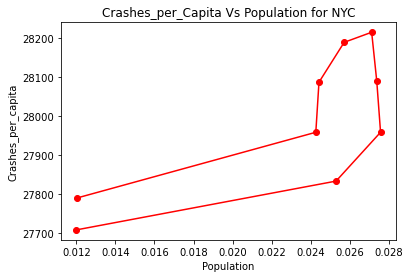

In [53]:
plt.plot(crashes_population_sorted['Crashes_per_capita'], crashes_population_sorted['Population_Density'], color='red', marker='o')
plt.title('Crashes_per_Capita Vs Population for NYC')
plt.xlabel('Population')
plt.ylabel('Crashes_per_capita')
plt.show()

In [54]:
crashes_population_subset = crashes_population.drop([3,4],0)

In [55]:
crashes_population_subset_sorted = crashes_population_subset.sort_values(by=['Year'])

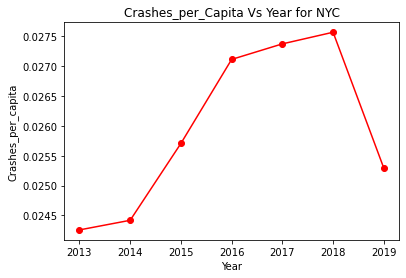

In [56]:
plt.plot(crashes_population_subset_sorted['Year'], crashes_population_subset_sorted['Crashes_per_capita'], color='red', marker='o')
plt.title('Crashes_per_Capita Vs Year for NYC')
plt.xlabel('Year')
plt.ylabel('Crashes_per_capita')
plt.show()

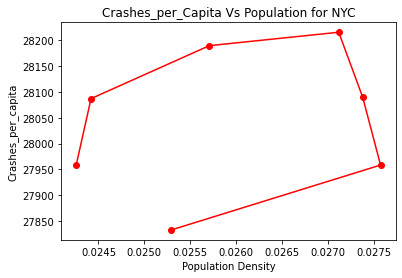

In [57]:
plt.plot(crashes_population_subset_sorted['Crashes_per_capita'], crashes_population_subset_sorted['Population_Density'], color='red', marker='o')
plt.title('Crashes_per_Capita Vs Population for NYC')
plt.xlabel('Population Density')
plt.ylabel('Crashes_per_capita')
plt.show()

## Hypothesis

#### Crash locations are not random. The collisions are bound to specific areas due to a badly planned network of roads/traffic signs.

In [72]:
mapbox_access_token = 'pk.eyJ1IjoiYWdhcndhbGFkYXJzaCIsImEiOiJja2h5ZGYyd3UwZTN3MnFwYzM1YW9qNnFvIn0.SasVV15822weUxlZ3G0P8Q'

fig = go.Figure(go.Scattermapbox(
    lat=crashes[(crashes['BOROUGH'] == 'STATEN ISLAND') &
                (crashes['CRASH_YEAR'] == 2020)]['LATITUDE'].tolist(),
    lon=crashes[(crashes['BOROUGH'] == 'STATEN ISLAND') &
                (crashes['CRASH_YEAR'] == 2020)]['LONGITUDE'].tolist(),
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=5
    ),
    text=crashes[(crashes['BOROUGH'] == 'STATEN ISLAND') & 
                 (crashes['CRASH_YEAR'] == 2020)]['CONTRIBUTING FACTOR VEHICLE 1'],
))

fig.update_layout(
    hovermode='closest',
    width=960,
    height=600,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=40.7,
            lon=-74
        ),
        pitch=0,
        zoom=8
    )
)

fig.show()